<a href="https://colab.research.google.com/github/guebin/DL2024/blob/main/posts/06wk-1.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" style="text-align: left"></a>

# 1. 강의영상

{{<video https://youtu.be/playlist?list=PLQqh36zP38-wTzMRmZzvr2TL12DNo6jXF&si=RnG6_-uhn9Yb57nU >}}

# 2. Imports

In [23]:
import torch
import torchvision
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import fastai.vision.all 

# 3. torch.eigensum

## A. transpose

In [24]:
tsr = torch.arange(12).reshape(4,3)
tsr

tensor([[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8],
        [ 9, 10, 11]])

In [25]:
tsr.t()

tensor([[ 0,  3,  6,  9],
        [ 1,  4,  7, 10],
        [ 2,  5,  8, 11]])

In [26]:
torch.einsum('ij->ji',tsr)

tensor([[ 0,  3,  6,  9],
        [ 1,  4,  7, 10],
        [ 2,  5,  8, 11]])

## B. 행렬곱

In [27]:
tsr1 = torch.arange(12).reshape(4,3).float()
tsr2 = torch.arange(15).reshape(3,5).float()

In [28]:
tsr1.shape

torch.Size([4, 3])

In [29]:
tsr2.shape

torch.Size([3, 5])

In [30]:
tsr1 @ tsr2

tensor([[ 25.,  28.,  31.,  34.,  37.],
        [ 70.,  82.,  94., 106., 118.],
        [115., 136., 157., 178., 199.],
        [160., 190., 220., 250., 280.]])

In [31]:
torch.einsum('ij,jk -> ik',tsr1,tsr2) 

tensor([[ 25.,  28.,  31.,  34.,  37.],
        [ 70.,  82.,  94., 106., 118.],
        [115., 136., 157., 178., 199.],
        [160., 190., 220., 250., 280.]])

## C. 이미지변환

In [32]:
r = torch.zeros(16).reshape(4,4) + 1.0
g = torch.zeros(16).reshape(4,4)
b = torch.zeros(16).reshape(4,4)
img_plt = torch.stack([r,g,b],axis=-1) # matplotlib 를 쓰기 위해서는 이미지가 이렇게 저장되어있어야한다. 
img_torch = torch.stack([r,g,b],axis=0).reshape(1,3,4,4) # torch를 쓰기 위해서는 이미지가 이렇게 저장되어있어야한다. 

In [33]:
img_plt.shape, img_torch.shape

(torch.Size([4, 4, 3]), torch.Size([1, 3, 4, 4]))

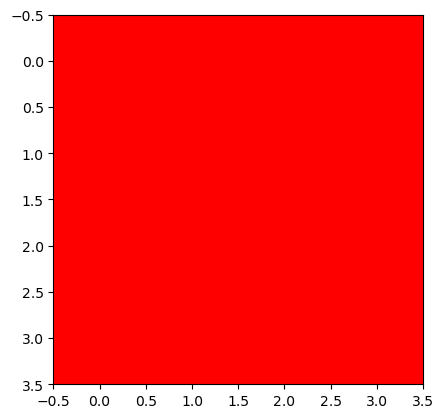

In [34]:
plt.imshow(img_plt)

만약에 `img_torch`를 matplotlib 으로 보고싶다면? 

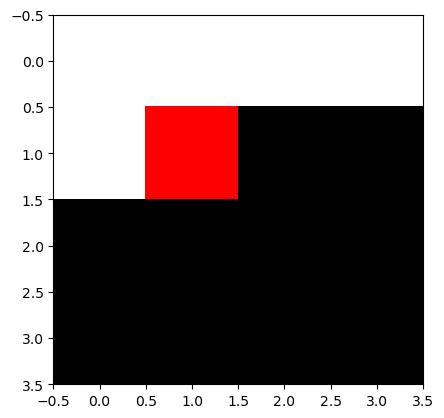

In [35]:
# 잘못된코드
plt.imshow(img_torch.reshape(4,4,3))

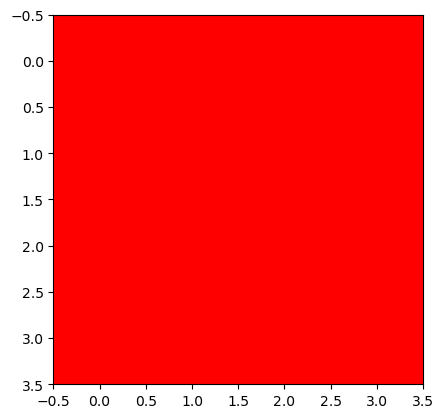

In [36]:
# 올바른코드
plt.imshow(torch.einsum('ocij -> ijc',img_torch))

# 4. MNIST -- 직접설계

In [37]:
path = fastai.data.external.untar_data(fastai.data.external.URLs.MNIST)
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/1').ls()])
X2 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/2').ls()])
X = torch.concat([X0,X1,X2])/255
y = torch.nn.functional.one_hot(torch.tensor([0]*len(X0) + [1]*len(X1) + [2]*len(X2))).float()
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'testing/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'testing/1').ls()])
X2 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'testing/2').ls()])
XX = torch.concat([X0,X1,X2])/255
yy = torch.nn.functional.one_hot(torch.tensor([0]*len(X0) + [1]*len(X1) + [2]*len(X2))).float()

In [38]:
print(X.shape,'\t',X.dtype)
print(y.shape,'\t\t\t',y.dtype)
print(XX.shape,'\t',XX.dtype)
print(yy.shape,'\t\t\t',yy.dtype)

torch.Size([18623, 1, 28, 28]) 	 torch.float32
torch.Size([18623, 3]) 			 torch.float32
torch.Size([3147, 1, 28, 28]) 	 torch.float32
torch.Size([3147, 3]) 			 torch.float32


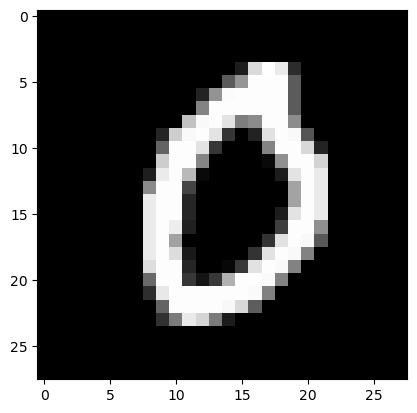

In [39]:
plt.imshow(torch.einsum('cij -> ijc',X[0]),cmap="gray")

## A. y: (n,3)-float 

In [40]:
# Step1: 데이터정리 (dls생성)
ds = torch.utils.data.TensorDataset(X,y)
dl = torch.utils.data.DataLoader(ds,batch_size=128) 
# Step2: 적합에 필요한 오브젝트 생성
net1 = torch.nn.Sequential(
    torch.nn.Conv2d(1,16,(5,5)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2,2)),
    torch.nn.Flatten()
)
net2 = torch.nn.Sequential(
    torch.nn.Linear(2304,3),
)
net = torch.nn.Sequential(
    net1, # 2d-part
    net2, # 1d-part 
)
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(net.parameters())
# Step3: 적합 
net.to("cuda:0")
for epoc in range(10):
    for xi,yi in dl:
        ## 1
        ## 2
        loss = loss_fn(net(xi.to("cuda:0")),yi.to("cuda:0"))
        ## 3 
        loss.backward()
        ## 4 
        optimizr.step()
        optimizr.zero_grad()
net.to("cpu")
# Step4: 예측 및 평가 
print(f'train: {(net(X).data.argmax(axis=1) == y.argmax(axis=1)).float().mean():.4f}')
print(f'val: {(net(XX).data.argmax(axis=1) == yy.argmax(axis=1)).float().mean():.4f}')

train: 0.9851
val: 0.9898


## B. y: (n,)-int

In [41]:
y = y.argmax(axis=-1)
yy = yy.argmax(axis=-1)
y,yy

(tensor([0, 0, 0,  ..., 2, 2, 2]), tensor([0, 0, 0,  ..., 2, 2, 2]))

In [42]:
print(X.shape,'\t',X.dtype)
print(y.shape,'\t\t',y.dtype)
print(XX.shape,'\t',XX.dtype)
print(yy.shape,'\t\t',yy.dtype)

torch.Size([18623, 1, 28, 28]) 	 torch.float32
torch.Size([18623]) 		 torch.int64
torch.Size([3147, 1, 28, 28]) 	 torch.float32
torch.Size([3147]) 		 torch.int64


In [43]:
# Step1: 데이터정리 (dls생성)
ds = torch.utils.data.TensorDataset(X,y)
dl = torch.utils.data.DataLoader(ds,batch_size=128) 
# Step2: 적합에 필요한 오브젝트 생성
net1 = torch.nn.Sequential(
    torch.nn.Conv2d(1,16,(5,5)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2,2)),
    torch.nn.Flatten()
)
net2 = torch.nn.Sequential(
    torch.nn.Linear(2304,3),
)
net = torch.nn.Sequential(
    net1, # 2d-part
    net2, # 1d-part 
)
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(net.parameters())
# Step3: 적합 
net.to("cuda:0")
for epoc in range(10):
    for xi,yi in dl:
        ## 1
        ## 2
        loss = loss_fn(net(xi.to("cuda:0")),yi.to("cuda:0"))
        ## 3 
        loss.backward()
        ## 4 
        optimizr.step()
        optimizr.zero_grad()
net.to("cpu")
# Step4: 예측 및 평가 
print(f'train: {(net(X).data.argmax(axis=1) == y).float().mean():.4f}') # <-- 여기수정
print(f'val: {(net(XX).data.argmax(axis=1) == yy).float().mean():.4f}') # <-- 여기수정

train: 0.9836
val: 0.9895


# 5. Fashion-MNIST -- fastai

`-` Data

In [44]:
df_train=pd.read_csv('https://media.githubusercontent.com/media/guebin/PP2023/main/posts/fashion-mnist_train.csv')
df_test=pd.read_csv('https://media.githubusercontent.com/media/guebin/PP2023/main/posts/fashion-mnist_test.csv')
def rshp(row):
    return row.reshape(1,28,28)
X = torch.tensor(np.apply_along_axis(rshp,axis=1,arr=np.array(df_train.iloc[:,1:]))).float()
XX  = torch.tensor(np.apply_along_axis(rshp,axis=1,arr=np.array(df_test.iloc[:,1:]))).float()
y = torch.tensor(np.array(df_train.label))
yy  = torch.tensor(np.array(df_test.label))

In [45]:
print(X.shape,'\t',X.dtype)
print(y.shape,'\t\t\t',y.dtype)
print(XX.shape,'\t',XX.dtype)
print(yy.shape,'\t\t\t',yy.dtype)

torch.Size([60000, 1, 28, 28]) 	 torch.float32
torch.Size([60000]) 			 torch.int64
torch.Size([10000, 1, 28, 28]) 	 torch.float32
torch.Size([10000]) 			 torch.int64


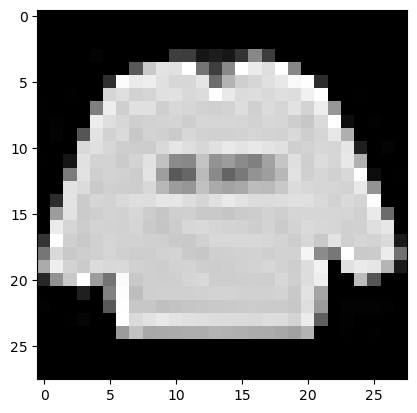

In [46]:
plt.imshow(torch.einsum('cij -> ijc',X[0]),cmap="gray")

## A. torch

In [47]:
# Step1: 데이터정리 (dls생성)
ds = torch.utils.data.TensorDataset(X,y)
dl = torch.utils.data.DataLoader(ds,batch_size=128) 
# Step2: 적합에 필요한 오브젝트 생성
net1 = torch.nn.Sequential(
    torch.nn.Conv2d(1,16,(5,5)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2,2)),
    torch.nn.Flatten()
)
net2 = torch.nn.Sequential(
    torch.nn.Linear(2304,10),
)
net = torch.nn.Sequential(
    net1, # 2d-part
    net2, # 1d-part 
)
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(net.parameters())
# Step3: 적합 
net.to("cuda:0")
for epoc in range(10):
    for xi,yi in dl:
        ## 1
        ## 2
        loss = loss_fn(net(xi.to("cuda:0")),yi.to("cuda:0"))
        ## 3 
        loss.backward()
        ## 4 
        optimizr.step()
        optimizr.zero_grad()
net.to("cpu")
# Step4: 예측 및 평가 
print(f'train: {(net(X).data.argmax(axis=1) == y).float().mean():.4f}')
print(f'val: {(net(XX).data.argmax(axis=1) == yy).float().mean():.4f}')

train: 0.9077
val: 0.8723


## B. fastai

In [48]:
# Step1: 데이터정리 (dls생성)
ds1 = torch.utils.data.TensorDataset(X,y)
ds2 = torch.utils.data.TensorDataset(XX,yy)
dl1 = torch.utils.data.DataLoader(ds1,batch_size=128) 
dl2 = torch.utils.data.DataLoader(ds2,batch_size=100) 
dls = fastai.data.core.DataLoaders(dl1,dl2)
# Step2: 적합에 필요한 오브젝트 생성
net1 = torch.nn.Sequential(
    torch.nn.Conv2d(1,16,(5,5)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2,2)),
    torch.nn.Flatten()
)
net2 = torch.nn.Sequential(
    torch.nn.Linear(2304,10),
)
net = torch.nn.Sequential(
    net1, # 2d-part
    net2, # 1d-part 
)
loss_fn = torch.nn.CrossEntropyLoss()
#optimizr = torch.optim.Adam(net.parameters())
lrnr = fastai.learner.Learner(
    dls=dls,
    model=net,
    loss_func=loss_fn,
    #--#
    metrics=[fastai.metrics.accuracy]
)
# Step3: 적합 
lrnr.fit(10)
# Step4: 예측 및 평가 

lrnr.model.to("cpu")
print(f'train: {(lrnr.model(X).data.argmax(axis=1) == y).float().mean():.4f}')
print(f'val: {(lrnr.model(XX).data.argmax(axis=1) == yy).float().mean():.4f}')

epoch,train_loss,valid_loss,accuracy,time
0,0.484642,0.444805,0.858300,00:01
1,0.393360,0.413498,0.862200,00:01
2,0.340997,0.403366,0.866100,00:01
3,0.310863,0.421401,0.866300,00:01
4,0.291870,0.426586,0.865400,00:01
5,0.277852,0.429622,0.866500,00:01
6,0.266723,0.444076,0.870700,00:01
7,0.260530,0.456487,0.871100,00:01
8,0.253032,0.458816,0.875000,00:01
9,0.247392,0.483315,0.870800,00:01


train: 0.9124
val: 0.8708


# 6. ImageNet -- 직접설계/transfer 

## A. 알렉스넷[@krizhevsky2012imagenet]의 의미

`-` 야사로 배우는 인공지능: <https://brunch.co.kr/@hvnpoet/109>

## B. 알렉스넷의 아키텍처 써보기 

`-` 알렉스넷의 아키텍처: 

-ref: <https://en.wikipedia.org/wiki/AlexNet#:~:text=AlexNet%20is%20the%20name%20of,at%20the%20University%20of%20Toronto.>

![](https://upload.wikimedia.org/wikipedia/commons/thumb/c/cc/Comparison_image_neural_networks.svg/960px-Comparison_image_neural_networks.svg.png)

`-` 재미삼아 써보면.. 

In [49]:
img = torch.zeros(1,3*227*227).reshape(1,3,227,227)
img.shape

torch.Size([1, 3, 227, 227])

In [50]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(3,96,kernel_size=(11,11),stride=4),
    torch.nn.ReLU(),    
    torch.nn.MaxPool2d((3,3),stride=2), # default stride는 3
    torch.nn.Conv2d(96,256,kernel_size=(5,5),padding=2),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((3,3),stride=2), # default stride는 3
    torch.nn.Conv2d(256,384,kernel_size=(3,3),padding=1),
    torch.nn.ReLU(),
    torch.nn.Conv2d(384,384,kernel_size=(3,3),padding=1),
    torch.nn.ReLU(),    
    torch.nn.Conv2d(384,256,kernel_size=(3,3),padding=1),
    torch.nn.ReLU(),    
    torch.nn.MaxPool2d((3,3),stride=2),
    torch.nn.Flatten(),
    torch.nn.Linear(9216,4096),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(4096,4096),        
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),    
    torch.nn.Linear(4096,1000),
)

`-` 참고사항: `torchvision.models.alexnet()`을 이용하여 네크워크를 선언할 수도 있음. 

In [51]:
torchvision.models.alexnet()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

::: {.callout-note}
직접구현한 알렉스넷과 `torchvision.models.alexnet()`를 이용한 알렉스넷은 약간다름. 

그 이유는 파이토치에서는 원래 논문에서 구현된 알렉스넷이 아니라 이후 수정된 알렉스넷을 사용하기 때문임. 이 내용은 파이토치 공식홈페이지에서 아래와 같이 명시되어있음. 

```
AlexNet was originally introduced in the ImageNet Classification with Deep Convolutional Neural Networks paper. Our implementation is based instead on the “One weird trick” paper above.
```

ref: <https://pytorch.org/vision/main/models/generated/torchvision.models.alexnet.html>
:::

## C. 알렉스넷으로 ImageNet 적합

In [52]:
pass # 데이터가 너무 커서.. 코랩에서 못할것같아요

# 7. CIFAR10 -- transfer

## A. `dls` 만들자

`-` X,y를 얻자. 

In [53]:
path = fastai.data.external.untar_data(fastai.data.external.URLs.CIFAR)
path.ls()

(#3) [Path('/root/.fastai/data/cifar10/train'),Path('/root/.fastai/data/cifar10/labels.txt'),Path('/root/.fastai/data/cifar10/test')]

In [54]:
labels = [str(l).split('/')[-1] for l in (path/'train').ls()]
labels

['deer',
 'airplane',
 'ship',
 'dog',
 'automobile',
 'truck',
 'cat',
 'frog',
 'horse',
 'bird']

In [55]:
X = torch.stack([torchvision.io.read_image(str(fname)) for l in labels for fname in (path/f'train/{l}').ls()],axis=0).float()/255
XX = torch.stack([torchvision.io.read_image(str(fname)) for l in labels for fname in (path/f'test/{l}').ls()],axis=0).float()/255
y = torch.tensor([i for i,l in enumerate(labels) for fname in (path/f'train/{l}').ls()])
yy = torch.tensor([i for i,l in enumerate(labels) for fname in (path/f'test/{l}').ls()])

In [56]:
print(X.shape,'\t',X.dtype)
print(y.shape,'\t\t\t',y.dtype)
print(XX.shape,'\t',XX.dtype)
print(yy.shape,'\t\t\t',yy.dtype)

torch.Size([50000, 3, 32, 32]) 	 torch.float32
torch.Size([50000]) 			 torch.int64
torch.Size([10000, 3, 32, 32]) 	 torch.float32
torch.Size([10000]) 			 torch.int64


`-` 데이터를 시각화해보자. 

Text(0.5, 1.0, 'cat,6')

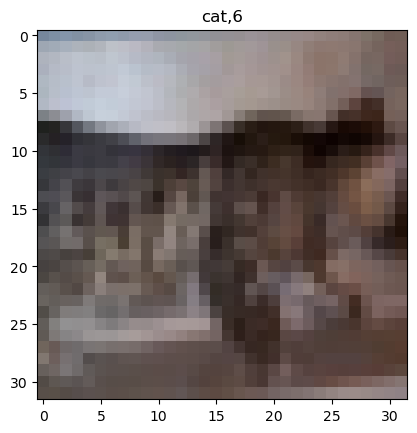

In [57]:
ylabel = [l for l in labels for fname in (path/f'train/{l}').ls()]
i = 30002
plt.imshow(torch.einsum('cij->ijc',X[i]))
plt.title(f'{ylabel[i]},{y[i]}')

- 그림이 너무 어려운데? 
- 맞추기 힘들겠는데.. 

`-` dls를 만들자. 

In [58]:
ds1 = torch.utils.data.TensorDataset(X,y)
ds2 = torch.utils.data.TensorDataset(XX,yy)
dl1 = torch.utils.data.DataLoader(ds1,batch_size=256,shuffle=True)
dl2 = torch.utils.data.DataLoader(ds2,batch_size=100)
dls = fastai.data.core.DataLoaders(dl1,dl2)

`-` 아래와 같이 쉽게 만들수도있음... 

In [59]:
# dls = fastai.vision.data.ImageDataLoaders.from_folder(path,train='train',valid='test')
# dls.show_batch()

## B. 수제네트워크로 학습

`-` 시도1: 이게 좀 힘들어요 ㅎㅎ

In [60]:
# Step1:
ds1 = torch.utils.data.TensorDataset(X,y)
ds2 = torch.utils.data.TensorDataset(XX,yy)
dl1 = torch.utils.data.DataLoader(ds1,batch_size=256)
dl2 = torch.utils.data.DataLoader(ds2,batch_size=100)
dls = fastai.data.core.DataLoaders(dl1,dl2)
# Step2:
net1 = torch.nn.Sequential(
    torch.nn.Conv2d(3,16,(5,5)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2,2)),
    torch.nn.Flatten()
)
net2 = torch.nn.Sequential(
    torch.nn.Linear(3136,10),
)
net = torch.nn.Sequential(
    net1, # 2d-part
    net2, # 1d-part 
)
loss_fn = torch.nn.CrossEntropyLoss()
lrnr = fastai.learner.Learner(
    dls=dls,
    model=net,
    loss_func=loss_fn,
    #--#
    metrics=[fastai.metrics.accuracy]
)
# Step3:
lrnr.fit(10)
# Step4: 
lrnr.model.to("cpu")
print(f'train: {(lrnr.model(X).data.argmax(axis=1) == y).float().mean():.4f}')
print(f'val: {(lrnr.model(XX).data.argmax(axis=1) == yy).float().mean():.4f}')

epoch,train_loss,valid_loss,accuracy,time
0,2.429019,2.301729,0.121900,00:00
1,2.867480,2.297742,0.121600,00:00
2,2.798708,2.350770,0.099900,00:00
3,2.378768,2.292685,0.116900,00:00
4,2.436424,2.289784,0.126600,00:00
5,2.972414,2.361609,0.122900,00:01
6,2.285441,5.540118,0.100300,00:00
7,2.908635,2.349017,0.131200,00:00
8,3.101591,3.855471,0.103200,00:00
9,2.130486,17.543028,0.100200,00:00


train: 0.1000
val: 0.1002


- ????

`-` 시도2: 셔플!

In [61]:
# Step1:
ds1 = torch.utils.data.TensorDataset(X,y)
ds2 = torch.utils.data.TensorDataset(XX,yy)
dl1 = torch.utils.data.DataLoader(ds1,batch_size=256,shuffle=True)
dl2 = torch.utils.data.DataLoader(ds2,batch_size=100)
dls = fastai.data.core.DataLoaders(dl1,dl2)
# Step2:
net1 = torch.nn.Sequential(
    torch.nn.Conv2d(3,16,(5,5)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2,2)),
    torch.nn.Flatten()
)
net2 = torch.nn.Sequential(
    torch.nn.Linear(3136,10),
)
net = torch.nn.Sequential(
    net1, # 2d-part
    net2, # 1d-part 
)
loss_fn = torch.nn.CrossEntropyLoss()
lrnr = fastai.learner.Learner(
    dls=dls,
    model=net,
    loss_func=loss_fn,
    #--#
    metrics=[fastai.metrics.accuracy]
)
# Step3:
lrnr.fit(10)
# Step4: 
lrnr.model.to("cpu")
print(f'train: {(lrnr.model(X).data.argmax(axis=1) == y).float().mean():.4f}')
print(f'val: {(lrnr.model(XX).data.argmax(axis=1) == yy).float().mean():.4f}')

epoch,train_loss,valid_loss,accuracy,time
0,1.629887,1.535057,0.463400,00:00
1,1.438346,1.392916,0.512500,00:00
2,1.355882,1.374366,0.518900,00:00
3,1.289650,1.298758,0.542500,00:01
4,1.256436,1.278826,0.555900,00:00
5,1.225732,1.244056,0.563800,00:00
6,1.204093,1.234391,0.563100,00:00
7,1.179638,1.228574,0.569700,00:00
8,1.163272,1.187201,0.585200,00:00
9,1.146735,1.199569,0.578300,00:00


train: 0.6101
val: 0.5783


- 셔플의 차이가 이렇게 크다니??

`-` 시도3: 복잡하게..

In [62]:
# Step1:
ds1 = torch.utils.data.TensorDataset(X,y)
ds2 = torch.utils.data.TensorDataset(XX,yy)
dl1 = torch.utils.data.DataLoader(ds1,batch_size=256,shuffle=True)
dl2 = torch.utils.data.DataLoader(ds2,batch_size=100)
dls = fastai.data.core.DataLoaders(dl1,dl2)
# Step2:
net1 = torch.nn.Sequential(
    torch.nn.Conv2d(3,256,(5,5)),
    torch.nn.ReLU(),
    torch.nn.Conv2d(256,64,(5,5)),
    torch.nn.ReLU(),
    torch.nn.Conv2d(64,16,(5,5)),
    torch.nn.MaxPool2d((2,2)),
    torch.nn.Flatten()
)
net2 = torch.nn.Sequential(
    torch.nn.Linear(1600,10),
)
net = torch.nn.Sequential(
    net1, # 2d-part
    net2, # 1d-part 
)
loss_fn = torch.nn.CrossEntropyLoss()
lrnr = fastai.learner.Learner(
    dls=dls,
    model=net,
    loss_func=loss_fn,
    #--#
    metrics=[fastai.metrics.accuracy]
)
# Step3:
lrnr.fit(10)
# Step4: 
# 코랩사용시 아래는 주석처리할것 (이유: 코랩의 RAM이 충분하지 않음) valiation set의 accuracy는 fastai결과로 확인할것. 
lrnr.model.to("cpu")
print(f'train: {(lrnr.model(X).data.argmax(axis=1) == y).float().mean():.4f}')
print(f'val: {(lrnr.model(XX).data.argmax(axis=1) == yy).float().mean():.4f}')

epoch,train_loss,valid_loss,accuracy,time
0,1.476197,1.479258,0.465500,00:02
1,1.310572,1.284226,0.538200,00:02
2,1.204503,1.222977,0.572300,00:02
3,1.102717,1.093513,0.615500,00:02
4,1.042015,1.047397,0.627400,00:02
5,0.998049,1.077097,0.621600,00:02
6,0.985487,0.986339,0.660600,00:02
7,0.924648,0.977845,0.663900,00:02
8,0.897980,0.997572,0.658000,00:02
9,0.879995,0.981113,0.660500,00:02


train: 0.7026
val: 0.6605


## C. TransferLearning으로 학습

`-` ResNet18을 다운로드 

In [63]:
net = torchvision.models.resnet18()
net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

`-` 마지막의 레이어만 수정 

In [64]:
net.fc = torch.nn.Linear(512,10)

`-` 학습해보자. 

In [65]:
# Step1:
ds1 = torch.utils.data.TensorDataset(X,y)
ds2 = torch.utils.data.TensorDataset(XX,yy)
dl1 = torch.utils.data.DataLoader(ds1,batch_size=64,shuffle=True)
dl2 = torch.utils.data.DataLoader(ds2,batch_size=100)
dls = fastai.data.core.DataLoaders(dl1,dl2)
# Step2:
net = torchvision.models.resnet18()
net.fc = torch.nn.Linear(512,10)
loss_fn = torch.nn.CrossEntropyLoss()
lrnr = fastai.learner.Learner(
    dls=dls,
    model=net,
    loss_func=loss_fn,
    #--#
    metrics=[fastai.metrics.accuracy]
)
# Step3:
lrnr.fit(10)
# Step4: 
# 코랩사용시 아래는 주석처리할것 (이유: 코랩의 RAM이 충분하지 않음) valiation set의 accuracy는 fastai결과로 확인할것. 
lrnr.model.to("cpu")
print(f'train: {(lrnr.model(X).data.argmax(axis=1) == y).float().mean():.4f}') # 
print(f'val: {(lrnr.model(XX).data.argmax(axis=1) == yy).float().mean():.4f}')

epoch,train_loss,valid_loss,accuracy,time
0,1.157889,1.281547,0.540200,00:11
1,0.924410,1.179057,0.596200,00:11
2,0.797667,0.948804,0.678700,00:11
3,0.681159,0.877607,0.699700,00:11
4,0.568150,0.818889,0.726400,00:11
5,0.509804,0.842927,0.725800,00:11
6,0.428966,0.836546,0.736100,00:11
7,0.378433,0.825805,0.753200,00:11
8,0.297282,0.917828,0.734000,00:11
9,0.244396,0.876090,0.763200,00:11


train: 0.9523
val: 0.7632


::: {.callout-caution}
통계학과서버를 이용하시는 분들은 다른 학생들을 위하여 실습이 끝난이후 커널을 죽여주시기 바랍니다. 그렇지 않으면 GPU메모리 부족으로 다른학생들이 실습하기 어렵습니다.(무슨말인지 모르겠으면 저에게 물어보세요)
:::

# 8. HW

없어요..